In [1]:
import pandas as pd

In [18]:
senssor_data_2 = pd.read_csv("../data/raw/data9.csv")

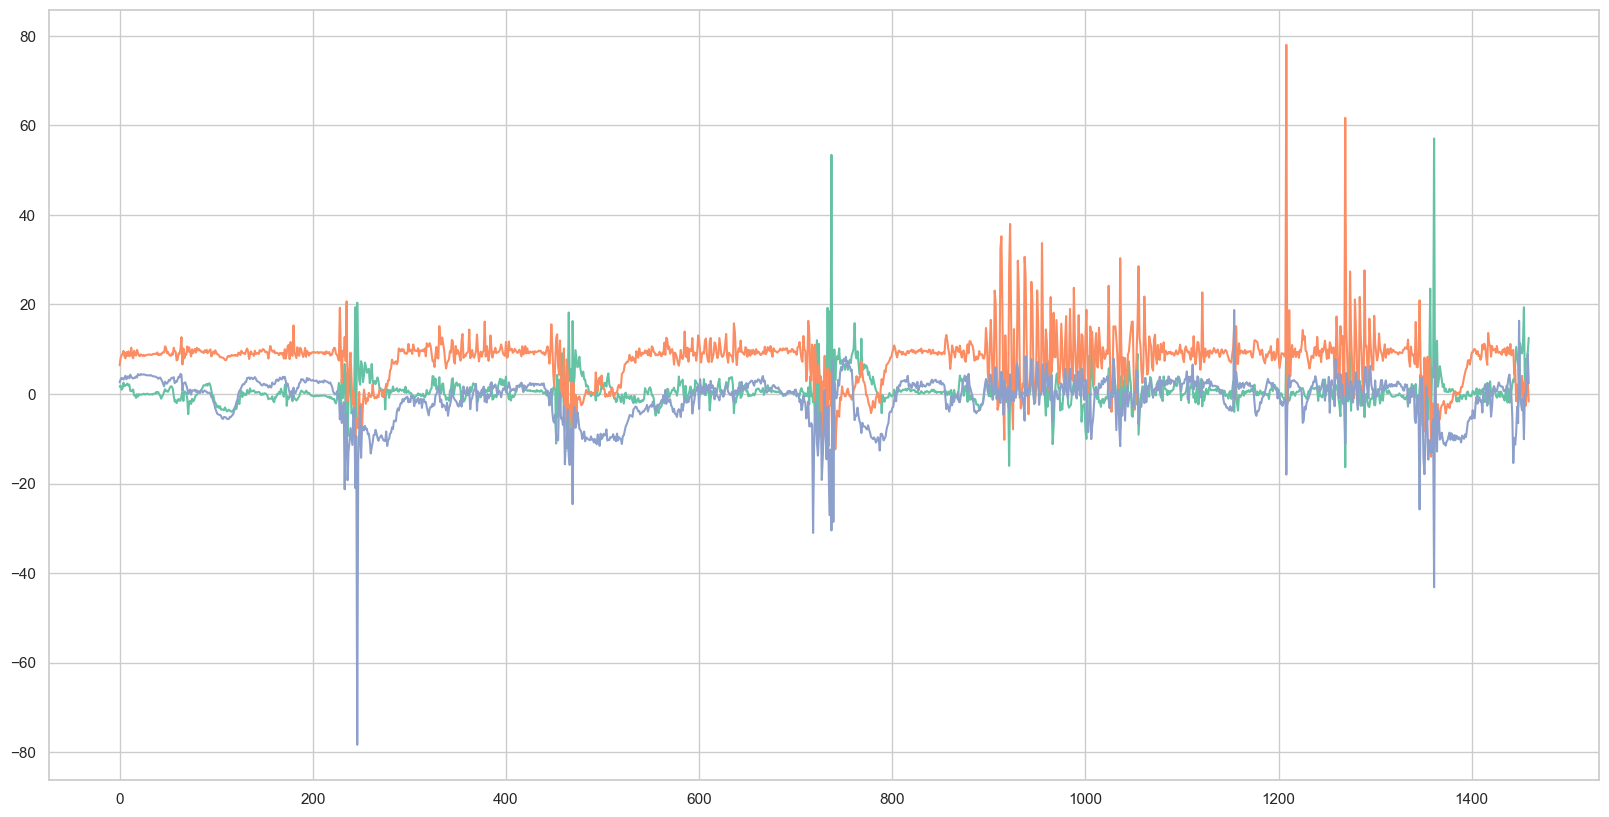

In [19]:
# plot sensor data, line plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_palette("Set2")

plt.figure(figsize=(20, 10))
plt.plot(senssor_data_2["ax"], label="ax")
plt.plot(senssor_data_2["ay"], label="ay")
plt.plot(senssor_data_2["az"], label="az")

In [20]:
# plot using plotly express
import plotly.express as px

# plot all three axis
fig = px.line(senssor_data_2, x=senssor_data_2.index, y=["ax", "ay", "az"])
fig.show()

In [41]:
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz

class MotionFeatureCalculator:
    def __init__(self, df, timestamp_col, accel_cols, time_unit="ms"):
        self.df = df
        self.timestamp_col = timestamp_col
        self.accel_cols = accel_cols
        self.time_unit = time_unit

    def calculate_time_interval(self):
        self.df[self.timestamp_col] = pd.to_datetime(self.df[self.timestamp_col])
        self.df["time_interval"] = (
            self.df[self.timestamp_col].diff().fillna(pd.Timedelta(seconds=0))
        )
        self.df["time_interval"] = self.df["time_interval"].dt.total_seconds()
        time_divisor = 1000 if self.time_unit == "ms" else 1
        self.df["time_interval"] /= time_divisor

    def calculate_velocity_displacement(self):
        for axis in self.accel_cols:
            velocity_col = f"v{axis[-1]}"
            self.df[velocity_col] = cumtrapz(
                self.df[axis], self.df["time_interval"], initial=0
            )

            displacement_col = f"d{axis[-1]}"
            self.df[displacement_col] = cumtrapz(
                self.df[velocity_col], self.df["time_interval"], initial=0
            )

    def calculate_angles(self):
        for axis1, axis2 in [("ax", "ay"), ("ay", "az"), ("az", "ax")]:
            angle_col = f"angle_{axis1[-1]}{axis2[-1]}"
            self.df[angle_col] = np.degrees(
                np.arctan2(self.df[axis1], self.df[axis2])
            )

    def calculate_g_force(self):
        self.df["g_force"] = np.sqrt(
            self.df["ax"] ** 2 + self.df["ay"] ** 2 + self.df["az"] ** 2
        )

    def calculate_jerk_orientation(self):
        self.df["jerk"] = (
            self.df["g_force"].diff().fillna(9.8) / self.df["time_interval"]
        )
        self.df["orientation_xy"] = np.degrees(
            np.arctan2(self.df["ay"], self.df["ax"])
        )
        self.df["orientation_yz"] = np.degrees(
            np.arctan2(self.df["az"], self.df["ay"])
        )
        self.df["orientation_zx"] = np.degrees(
            np.arctan2(self.df["ax"], self.df["az"])
        )

    def calculate_magnitudes(self):
        self.df["magnitude_acceleration"] = np.sqrt(
            self.df["ax"] ** 2 + self.df["ay"] ** 2 + self.df["az"] ** 2
        )
        self.df["magnitude_velocity"] = np.sqrt(
            self.df["vx"] ** 2 + self.df["vy"] ** 2 + self.df["vz"] ** 2
        )
        self.df["magnitude_displacement"] = np.sqrt(
            self.df["dx"] ** 2 + self.df["dy"] ** 2 + self.df["dz"] ** 2
        )

    def calculate_impact_detection(self):
        self.df["impact_detection"] = self.df["jerk"].apply(
            lambda x: 1 if x > 120000 else 0
        )

    def calculate_all_features(self):
        self.calculate_time_interval()
        self.calculate_velocity_displacement()
        self.calculate_angles()
        self.calculate_g_force()
        self.calculate_jerk_orientation()
        self.calculate_magnitudes()
        self.calculate_impact_detection()
        return self.df


In [42]:
calculator = MotionFeatureCalculator(senssor_data_2, 'timestamp_local', ['ax', 'ay', 'az'])
updated_df = calculator.calculate_all_features()

/var/folders/z0/17ykh1n151x8y8rfk6dfkv500000gn/T/ipykernel_15838/1552954409.py:24: DeprecationWarning:

'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0

/var/folders/z0/17ykh1n151x8y8rfk6dfkv500000gn/T/ipykernel_15838/1552954409.py:29: DeprecationWarning:

'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0



In [43]:
# updated_df = calculate_motion_features(
#     senssor_data_2, "timestamp_local", ["ax", "ay", "az"]
# )
# updated_df.head()

In [44]:
updated_df.head()

timestamp            timestamp_local        ax        ay        az  \
0  190515181 2024-02-08 14:43:38.345153  1.624785  6.410601  2.581948   
1  190515257 2024-02-08 14:43:38.420290  1.871254  8.037778  3.249569   
2  190515333 2024-02-08 14:43:38.495250  0.957163  8.614470  3.596541   
3  190515410 2024-02-08 14:43:38.570359  1.277813  8.947083  3.429037   
4  190515487 2024-02-08 14:43:38.645000  2.510161  9.614705  3.225640   

   fall_state  time_interval        vx            dx        vy  ...  \
0           0       0.000000  0.000000  0.000000e+00  0.000000  ...   
1           0       0.000075  0.000131  4.934282e-09  0.000543  ...   
2           0       0.000075  0.000131  4.911056e-09  0.000541  ...   
3           0       0.000075  0.000131  4.930601e-09  0.000543  ...   
4           0       0.000075  0.000130  4.869380e-09  0.000538  ...   

    angle_zx    g_force          jerk  orientation_xy  orientation_yz  \
0  57.818352   7.099449           inf       75.777715       21.937714   
1  60.064648   8.869451  2.355700e+04       76.894559       22.012844   
2  75.097059   9.384048  6.864949e+03       83.659809       22.660536   
3  69.562352   9.666509  3.760690e+03       81.872043       20.969708   
4  52.110305  10.447402  1.046198e+04       75.368097       18.546102   

   orientation_zx  magnitude_acceleration  magnitude_velocity  \
0       32.181648                7.099449            0.000000   
1       29.935352                8.869451            0.000600   
2       14.902941                9.384048            0.000598   
3       20.437648                9.666509            0.000600   
4       37.889695               10.447402            0.000595   

   magnitude_displacement  impact_detection  
0            0.000000e+00                 1  
1            2.253744e-08                 0  
2            2.243140e-08                 0  
3            2.252065e-08                 0  
4            2.224109e-08                 0  

[5 rows x 25 columns]

In [38]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               1460 non-null   int64         
 1   timestamp_local         1460 non-null   datetime64[ns]
 2   ax                      1460 non-null   float64       
 3   ay                      1460 non-null   float64       
 4   az                      1460 non-null   float64       
 5   fall_state              1460 non-null   int64         
 6   time_interval           1460 non-null   float64       
 7   vx                      1460 non-null   float64       
 8   dx                      1460 non-null   float64       
 9   vy                      1460 non-null   float64       
 10  dy                      1460 non-null   float64       
 11  vz                      1460 non-null   float64       
 12  dz                      1460 non-null   float64 

In [39]:
# plot updated_df with all columns as line plot using polotlöy express
# these are the columns timestamp	ax	ay	az	recorded_at	time_interval	vx	dx	angle_xy	angle_yz	angle_zx	g_force	vy	dy	vz	dz

import plotly.express as px

# columns = timestamp	ax	ay	az	recorded_at	time_interval	vx	dx	angle_xy	angle_yz	angle_zx	g_force	vy	dy	vz	dz
fig = px.line(
    updated_df,
    x=updated_df.index,
    y=[
        "ax",
        "ay",
        "az",
        "vx",
        "vy",
        "vz",
        "dx",
        "dy",
        "dz",
        "angle_xy",
        "angle_yz",
        "angle_zx",
        "g_force",
        "jerk",
        "orientation_xy",
        "orientation_yz",
        "orientation_zx",
        "magnitude_acceleration",
        "magnitude_velocity",
        "magnitude_displacement",
        "impact_detection",
    ],
)

# add slider to plot
fig.update_xaxes(rangeslider_visible=True)

In [27]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplots with 7 rows
fig = make_subplots(rows=10, cols=1, shared_xaxes=True)

# Acceleration
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['ax'], name='ax'), row=1, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['ay'], name='ay'), row=1, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['az'], name='az'), row=1, col=1)

# Fall State
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['fall_state'], name='fall_state'), row=2, col=1)

# Velocity
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['vx'], name='vx'), row=3, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['vy'], name='vy'), row=3, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['vz'], name='vz'), row=3, col=1)

# Displacement
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['dx'], name='dx'), row=4, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['dy'], name='dy'), row=4, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['dz'], name='dz'), row=4, col=1)

# Angles
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['angle_xy'], name='angle_xy'), row=5, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['angle_yz'], name='angle_yz'), row=5, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['angle_zx'], name='angle_zx'), row=5, col=1)

# Force
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['g_force'], name='g_force'), row=6, col=1)

# Jerk
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['jerk'], name='jerk'), row=7, col=1)

# Force and Orientation
# fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['g_force'], name='g_force'), row=5, col=1)
# fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['jerk'], name='jerk'), row=5, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['orientation_xy'], name='orientation_xy'), row=8, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['orientation_yz'], name='orientation_yz'), row=8, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['orientation_zx'], name='orientation_zx'), row=8, col=1)

# Magnitudes
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['magnitude_acceleration'], name='magnitude_acceleration'), row=9, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['magnitude_velocity'], name='magnitude_velocity'), row=9, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['magnitude_displacement'], name='magnitude_displacement'), row=9, col=1)

# Impact Detection
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['impact_detection'], name='impact_detection'), row=10, col=1)

# add title for row 
# list of titles
titles = ["Acceleration", "Fall State", "Velocity", "Displacement", "Angles", "Force", "Jerk", "Force and Orientation", "Magnitudes", "Impact Detection"]
for i, title in enumerate(titles):
    fig.update_yaxes(title_text=title, row=i+1, col=1)

# Update layout
fig.update_layout(height=1400, width=1200, title_text="Sensor Data Detailed View")
# fig.update_xaxes(rangeslider_visible=True)

# Show plot
fig.show()



In [45]:
# plog plotly express gforce jerk impact detection fallstate with 4 rows
fig = make_subplots(rows=4, cols=1, shared_xaxes=True)

# Fall State
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['fall_state'], name='fall_state'), row=1, col=1)

# Force
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['g_force'], name='g_force'), row=2, col=1)

# Jerk
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['jerk'], name='jerk'), row=3, col=1)  

# Impact Detection
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['impact_detection'], name='impact_detection'), row=4, col=1)

# add title for row
# list of titles
titles = ["Fall State", "Force", "Jerk", "Impact Detection"]
for i, title in enumerate(titles):
    fig.update_yaxes(title_text=title, row=i+1, col=1)
    
fig.show()

In [12]:
# jerk value at point 997
jerk_at_997 = updated_df['jerk'][996]
print(jerk_at_997)

162936.7741723097


In [13]:
# save updated_df as csv file
# updated_df.to_csv("data.csv")

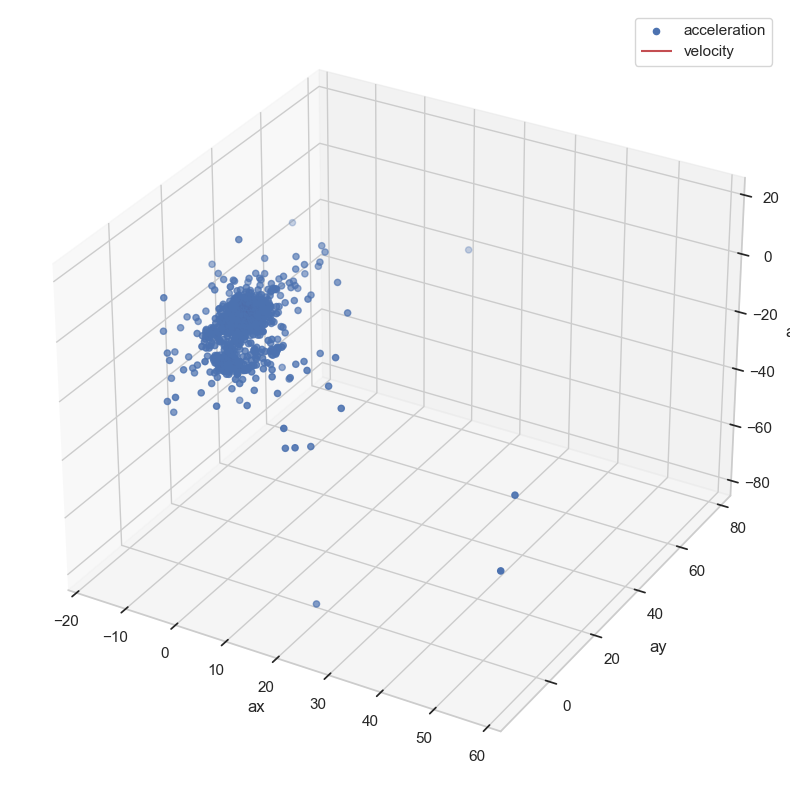

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# plot 3d plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    updated_df["ax"],
    updated_df["ay"],
    updated_df["az"],
    color="b",
    label="acceleration",
)

ax.quiver(
    updated_df["ax"],
    updated_df["ay"],
    updated_df["az"],
    updated_df["vx"],
    updated_df["vy"],
    updated_df["vz"],
    color="r",
    label="velocity",
    length=0.1,
)

ax.set_xlabel("ax")
ax.set_ylabel("ay")
ax.set_zlabel("az")

ax.legend()

plt.show()

In [15]:
# import numpy as np
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         super().__init__((0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def do_3d_projection(self, renderer=None):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

#         return np.min(zs)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0)
# a = Arrow3D([0, 1], [0, 0], [0, 0], **arrow_prop_dict)
# ax.add_artist(a)
# a = Arrow3D([0, 0], [0, 1], [0, 0], **arrow_prop_dict)
# ax.add_artist(a)
# a = Arrow3D([0, 0], [0, 0], [0, 1], **arrow_prop_dict)
# ax.add_artist(a)

# ax.text(0.0, 0.0, -0.1, r'$o$')
# ax.text(1.1, 0, 0, r'$x$')
# ax.text(0, 1.1, 0, r'$y$')
# ax.text(0, 0, 1.1, r'$z$')

# ax.view_init(azim=20, elev=10)
# plt.show()

In [16]:
# 3 d scatter plot of ax, ay, az using plotly express
import plotly.express as px

fig = px.scatter_3d(updated_df, x="ax", y="ay", z="az", color="g_force")
fig.show()

In [17]:
# display correlation heatmapn of updated_df using plotly express

import plotly.express as px

fig = px.imshow(updated_df.corr())
fig.show()

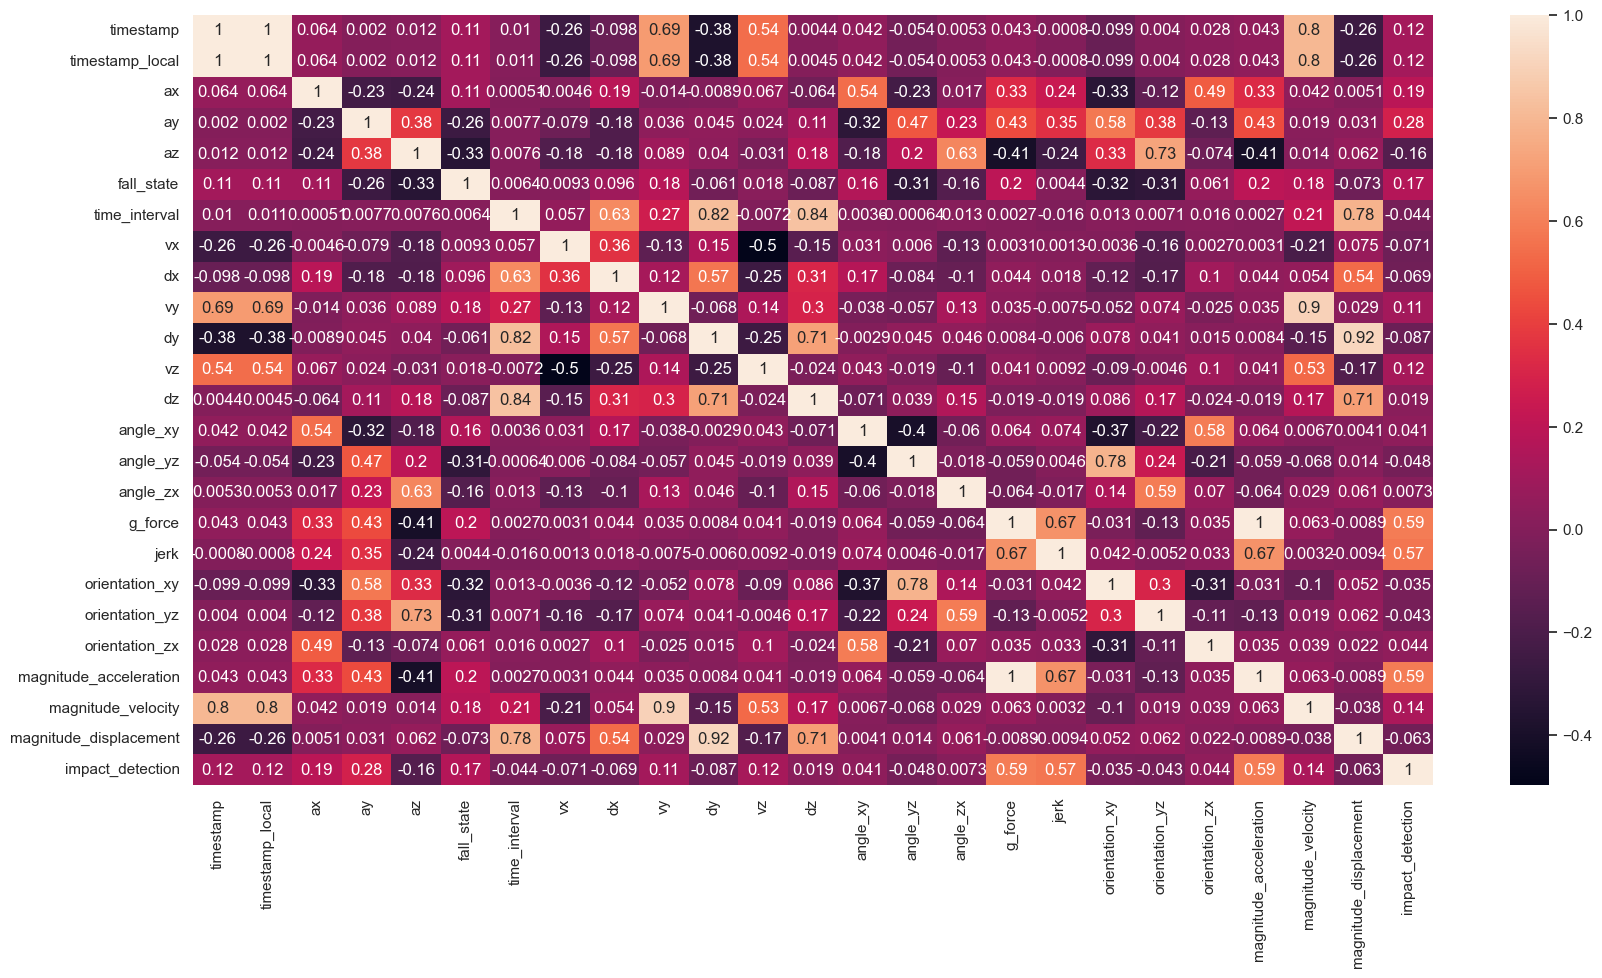

In [18]:
# correlation heatmap using seaborn
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_palette("Set2")

plt.figure(figsize=(20, 10))
sns.heatmap(updated_df.corr(), annot=True)
plt.show()


In [19]:
updated_df.columns

Index(['timestamp', 'timestamp_local', 'ax', 'ay', 'az', 'fall_state',
       'time_interval', 'vx', 'dx', 'vy', 'dy', 'vz', 'dz', 'angle_xy',
       'angle_yz', 'angle_zx', 'g_force', 'jerk', 'orientation_xy',
       'orientation_yz', 'orientation_zx', 'magnitude_acceleration',
       'magnitude_velocity', 'magnitude_displacement', 'impact_detection'],
      dtype='object')

In [20]:
# boxplot of g_force column
import plotly.express as px

fig = px.box(updated_df, y="jerk")
fig.show()

In [21]:
# plot impact detection column as a line plot
import plotly.express as px

fig = px.line(updated_df, x=updated_df.index, y=["impact_detection"])
fig.show()

In [22]:
# display only jerk column as a line plot
import plotly.express as px

fig = px.line(updated_df, x=updated_df.index, y=["jerk"])
fig.show()

In [23]:
updated_df

timestamp            timestamp_local         ax        ay        az  \
0     190515181 2024-02-08 14:43:38.345153   1.624785  6.410601  2.581948   
1     190515257 2024-02-08 14:43:38.420290   1.871254  8.037778  3.249569   
2     190515333 2024-02-08 14:43:38.495250   0.957163  8.614470  3.596541   
3     190515410 2024-02-08 14:43:38.570359   1.277813  8.947083  3.429037   
4     190515487 2024-02-08 14:43:38.645000   2.510161  9.614705  3.225640   
...         ...                        ...        ...       ...       ...   
1455  190626500 2024-02-08 14:45:29.658908   1.222776  2.780559  0.021536   
1456  190626576 2024-02-08 14:45:29.734030   7.760201 -2.629806 -0.284756   
1457  190626653 2024-02-08 14:45:29.823985   7.353406  1.567355  2.730308   
1458  190626729 2024-02-08 14:45:29.883704   9.440022  2.663307  8.997334   
1459  190626805 2024-02-08 14:45:29.973999  12.536446 -1.675036  2.376158   

      fall_state  time_interval        vx            dx        vy  ...  \
0              0       0.000000  0.000000  0.000000e+00  0.000000  ...   
1              0       0.000075  0.000131  4.934282e-09  0.000543  ...   
2              0       0.000075  0.000131  4.911056e-09  0.000541  ...   
3              0       0.000075  0.000131  4.930601e-09  0.000543  ...   
4              0       0.000075  0.000130  4.869380e-09  0.000538  ...   
...          ...            ...       ...           ...       ...  ...   
1455           0       0.000075  0.000400  7.549183e-09  0.001019  ...   
1456           0       0.000075  0.000398  7.421138e-09  0.001019  ...   
1457           0       0.000090  0.000510  1.415854e-08  0.001011  ...   
1458           0       0.000060  0.000256  2.568458e-09  0.000947  ...   
1459           0       0.000090  0.000592  1.554391e-08  0.000962  ...   

       angle_zx    g_force          jerk  orientation_xy  orientation_yz  \
0     57.818352   7.099449           inf       75.777715       21.937714   
1     60.064648   8.869451  2.355700e+04       76.894559       22.012844   
2     75.097059   9.384048  6.864949e+03       83.659809       22.660536   
3     69.562352   9.666509  3.760690e+03       81.872043       20.969708   
4     52.110305  10.447402  1.046198e+04       75.368097       18.546102   
...         ...        ...           ...             ...             ...   
1455   1.009019   3.037623 -2.511635e+05       66.262074        0.443762   
1456  -2.101492   8.198639  6.870179e+04      -18.720685     -173.820076   
1457  20.369881   7.998986 -2.219484e+03       12.032351       60.141683   
1458  43.624571  13.310119  8.893540e+04       15.755313       73.510686   
1459  10.732527  12.869123 -4.883936e+03       -7.610403      125.181332   

      orientation_zx  magnitude_acceleration  magnitude_velocity  \
0          32.181648                7.099449            0.000000   
1          29.935352                8.869451            0.000600   
2          14.902941                9.384048            0.000598   
3          20.437648                9.666509            0.000600   
4          37.889695               10.447402            0.000595   
...              ...                     ...                 ...   
1455       88.990981                3.037623            0.001165   
1456       92.101492                8.198639            0.001164   
1457       69.630119                7.998986            0.001207   
1458       46.375429               13.310119            0.001010   
1459       79.267473               12.869123            0.001203   

      magnitude_displacement  impact_detection  
0               0.000000e+00                 1  
1               2.253744e-08                 0  
2               2.243140e-08                 0  
3               2.252065e-08                 0  
4               2.224109e-08                 0  
...                      ...               ...  
1455            1.312156e-08                 0  
1456            1.276206e-08                 0  
1457            3.011